In [2]:
import sys
sys.path.append('/mnt/Work/LaGonaveFM/') # or use path '/home/aesgeorges/LaGonaveFM/scripts/'
from codebase.figures import *
from codebase.tools import *

import cmocean
import numpy as np
import netCDF4 as netcdf
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm import tqdm
from kalpana.plotting import plot_nc
from kalpana.export import fort14togdf
from kalpana.ADCIRC_tools import extract_ts_from_nc
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib as mpl

In [3]:
xs = [-74.2, -73.5, -72.9, -72.8]
ys = [19.3133, 19.3133, 19.3133, 19.3133]

Remember that you had to edit the Kalpana source code for this extract_ts_from_nc to work with those files (adding extra split for ! NCD present in file). Remember to put in a pull request.

## ADCIRC+SWAN Run

In [20]:
sim_dir = '../sims/Gonave_Surge_mangrove/'# ../sims/Gonave_Surge_mangrove/'
hotstart_dir = sim_dir+'hotstart/'

In [21]:
## load the NetCDF dataset from a specified file path
nc_f63 = netcdf.Dataset(hotstart_dir+'fort.63.nc', 'r')
nc_f74 = netcdf.Dataset(hotstart_dir+'fort.74.nc', 'r')

Map of transects for analysis

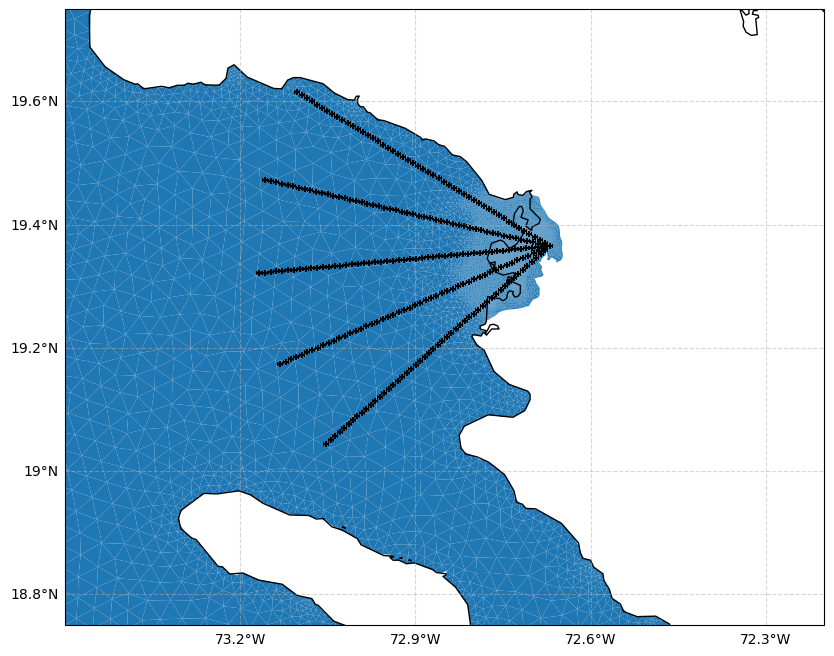

In [22]:
# Defining center of radius for arcs of observation stations
# Center is at the general midpoint of the mangrove forest in the open intertidal zone behind it.
center_x, center_y = -72.67, 19.365  

# List of radii (in NW increments) for the arcs of observation stations
radii = np.arange(0.5, 0., -0.01)  # Set distance between points to 0.05

# Define the start and end angles of the arc (in degrees)
start_angle = 150  # Starting angle of the arc
end_angle = 220  # Ending angle of the arc
num_points = 5

# Generate angles for the points along the arc
angles = np.linspace(np.radians(start_angle), np.radians(end_angle), num_points)

transects = []
for i in range(num_points):
    transects.append(make_transect(radii, angles[i], center_x, center_y))

mesh = fort14togdf(sim_dir+'/fort.14', epsgIn=4326, epsgOut=4326, fileintype='fort.14')

fig, ax = plot_transects(mesh, center_x, center_y, num_points, transects)
coast = cf.GSHHSFeature(scale='high')
ax.add_feature(coast)

## Plotting

In [23]:
variables = list(nc_f63.variables.keys())
nc_f63_list = nc_f63.variables['zeta'][:]

max_ele = nc_f63_list.max()
min_ele = nc_f63_list.min()
avg_ele = nc_f63_list.mean()

# Time Data and Quick Stats
print(nc_f63['time'])
print('\n')
print('Min: ' + str(nc_f63_list.min()))
print('Avg: ' + str(nc_f63_list.mean()))
print('Max: ' + str(nc_f63_list.max()))

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    long_name: model time
    standard_name: time
    units: seconds since 2016-09-13 12:00
    base_date: 2016-09-13 12:00                                                ! NCDATE
unlimited dimensions: time
current shape = (11084,)
filling on, default _FillValue of 9.969209968386869e+36 used


Min: -1.74
Avg: 0.043628807816569005
Max: 2.923626244512896


In [37]:
def slider_water_level(percent, nc_f63, nc_f74):

    total_timestep = nc_f63['time'].shape[0]
    timestep = int(total_timestep * percent / 100)

    fig, ax = plt.subplots(figsize = (12,12), subplot_kw={'projection': ccrs.PlateCarree()}, 
                        constrained_layout=True)
    cmap = cmocean.cm.balance
    cmap = cmocean.tools.crop(cmap, -1., round(max_ele, 1), 0)
    plot_nc(nc_f63, 'zeta', levels=np.arange(-1., round(max_ele, 1), 0.05), background_map=False, cbar=True, cb_label='Max water level [mMSL]', cmap=cmap, ts=timestep,
        ncvec=nc_f74, dxvec=0.1, dyvec=0.1, vecsc=1000, ax=ax, fig=fig)
    #plot_nc(nc, 'zeta', levels=np.arange(min_ele, max_ele, 0.02), background_map=False, cbar=True, cb_label='Max water level [mMSL]', cmap=cmap, ts=timestep,
     #   ncvec=nc_wind, dxvec=0.1, dyvec=0.1, vecsc=1000, ax=ax_inset, fig=fig)
    coast = cf.GSHHSFeature(scale='full', alpha=0.5)
    ax.add_feature(coast)

    ax.set_xlim(-73., -72.6)
    ax.set_ylim(19.1, 19.5)
    ax.set_title('ADCIRC+SWAN - fort.63.nc at timestep: '+str(timestep))

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mpl.ticker.MaxNLocator(nbins=5)
    gl.ylocator = mpl.ticker.MaxNLocator(nbins=3)

In [38]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Create the slider widget
slider = widgets.FloatSlider(
    value=58,            # Default value
    min=0,              # Minimum value
    max=100,              # Maximum value
    step=1,            # Step size
    description='Param:',  # Label
    continuous_update=False,  # Only update when slider is released
    orientation='horizontal',
    readout=True,         # Display the current value
    readout_format='.2f', # Format string for the readout
)

# Create output area for the plot
output = widgets.Output()

# Define update function
def update(change):
    with output:
        # Clear previous output
        output.clear_output(wait=True)
        
        # Call your figure function with the new parameter value
        slider_value = change['new']  # Get the new slider value
        fig = slider_water_level(slider_value, nc_f63, nc_f74)
        
        # Display the figure
        plt.show()

# Connect the update function to the slider
slider.observe(update, names='value')

# Initial display
with output:
    fig = slider_water_level(slider.value, nc_f63, nc_f74)
    plt.show()

# Display the slider and output
display(slider, output)

FloatSlider(value=58.0, continuous_update=False, description='Param:', step=1.0)

Output()

In [26]:
def plot_transect_data(transect_id, timestep, transects, nc, nc_wind, mesh):
    """
    Plots water elevation along a specified transect with an inset map showing the transect location.

    Parameters:
    - transect_id : int, ID of the transect to plot.
    - timestep    : int, timestep to extract data for.
    - transects   : list, list of transect dataframes containing longitude and latitude.
    - nc          : netCDF4.Dataset, NetCDF dataset containing water elevation data.
    - nc_wind     : netCDF4.Dataset, NetCDF dataset containing wind data.
    - mesh        : geopandas.GeoDataFrame, mesh data for plotting the inset map.

    Returns:
    - fig         : matplotlib.figure.Figure, the generated figure.
    - ax_main     : matplotlib.axes.Axes, the main plot axis.
    - ax_inset    : matplotlib.axes.Axes, the inset map axis
    """
    max_ele = round(nc.variables['zeta'][:].max(), 1)
    min_ele = round(nc.variables['zeta'][:].min(), 1)

    fig, ax_main = plt.subplots(figsize=(10, 6), dpi=100)
    ax_inset = fig.add_axes([0.17, 0.4, 0.38, 0.38], projection=ccrs.PlateCarree())  # [x, y, width, height] for inset
    
    # Extract water elevation data along the transect
    dfout, rep = extract_ts_from_nc(nc, list(zip(transects[transect_id].lon, transects[transect_id].lat)), variable='zeta', extractOut=False, closestIfDry=False)  
    time = dfout.iloc[timestep].name
    tr_elev = dfout.iloc[timestep].values  # Water elevation along the transect

    # Main plot
    ax_main.axhline(0, color='red', linestyle='--', linewidth=1)
    ax_main.grid(True)
    ax_main.set_title('Water elevation along transect at '+str(time))
    ax_main.plot(transects[transect_id].lon, tr_elev)
    ax_main.set_xlabel('Longitude along transect')
    ax_main.set_ylabel('Water Elevation')
    ax_main.set_xlim(transects[transect_id].lon.min(), transects[transect_id].lon.max())
    ax_main.set_ylim(min_ele, max_ele)

    # Inset plot
    for i in range(len(transects)):
        ax_inset.plot(transects[i].lon, transects[i].lat, 
                      transform=ccrs.PlateCarree(), color='k', alpha=0.2, linewidth=0.5, linestyle='--')
    ax_inset.plot(transects[transect_id].lon, transects[transect_id].lat, 
                  transform=ccrs.PlateCarree(), color='red', alpha=0.8, linewidth=0.7, linestyle='--')
    #mesh.plot(ax=ax_inset)
    
    cmap = plt.get_cmap('bwr_r')
    cmap = cmocean.tools.crop(cmap, min_ele, max_ele, 0)
    
    plot_nc(nc, 'zeta', levels=np.arange(min_ele, max_ele, 0.02), background_map=False, cbar=True, cb_label='Max water level [mMSL]', cmap=cmap, ts=timestep,
        ncvec=nc_wind, dxvec=0.1, dyvec=0.1, vecsc=1000, ax=ax_inset, fig=fig)
    coast = cf.GSHHSFeature(scale='high', alpha=0.5)
    ax_inset.add_feature(coast)
    ax_inset.set_xlim(-73.2, -72.6)
    ax_inset.set_ylim(19., 19.75)
    gl = ax_inset.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mpl.ticker.MaxNLocator(nbins=5)
    gl.ylocator = mpl.ticker.MaxNLocator(nbins=3)

    return fig, ax_main, ax_inset

(<Figure size 1000x600 with 3 Axes>,
 <AxesSubplot: title={'center': 'Water elevation along transect at 2016-10-04 21:07:06.401020'}, xlabel='Longitude along transect', ylabel='Water Elevation'>,
 <GeoAxes: xlabel='Longitude [deg]', ylabel='Latitude [deg]'>)

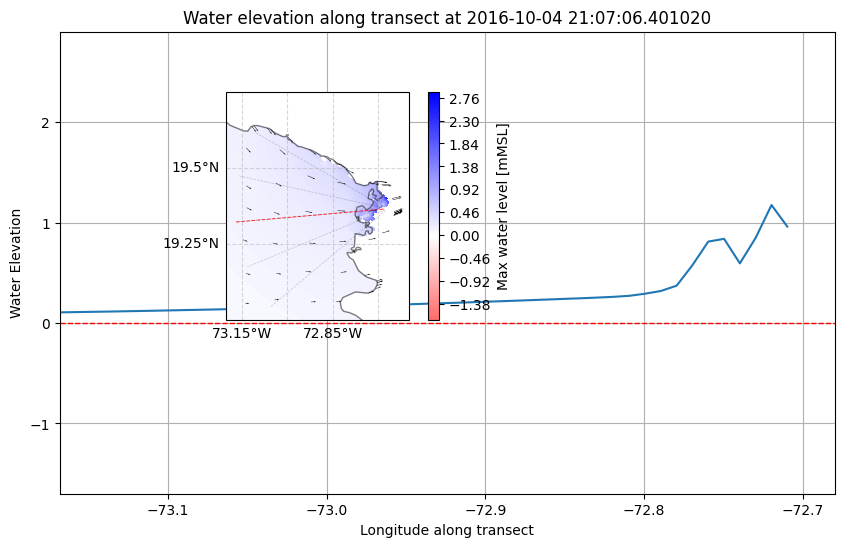

In [27]:
step = 6428
plot_transect_data(2, step, transects, nc_f63, nc_f74, mesh)
#plot_transect_data(0, step, transects, nc_f63, nc_f74, mesh)

<GeoAxesSubplot: xlabel='Longitude [deg]', ylabel='Latitude [deg]'>

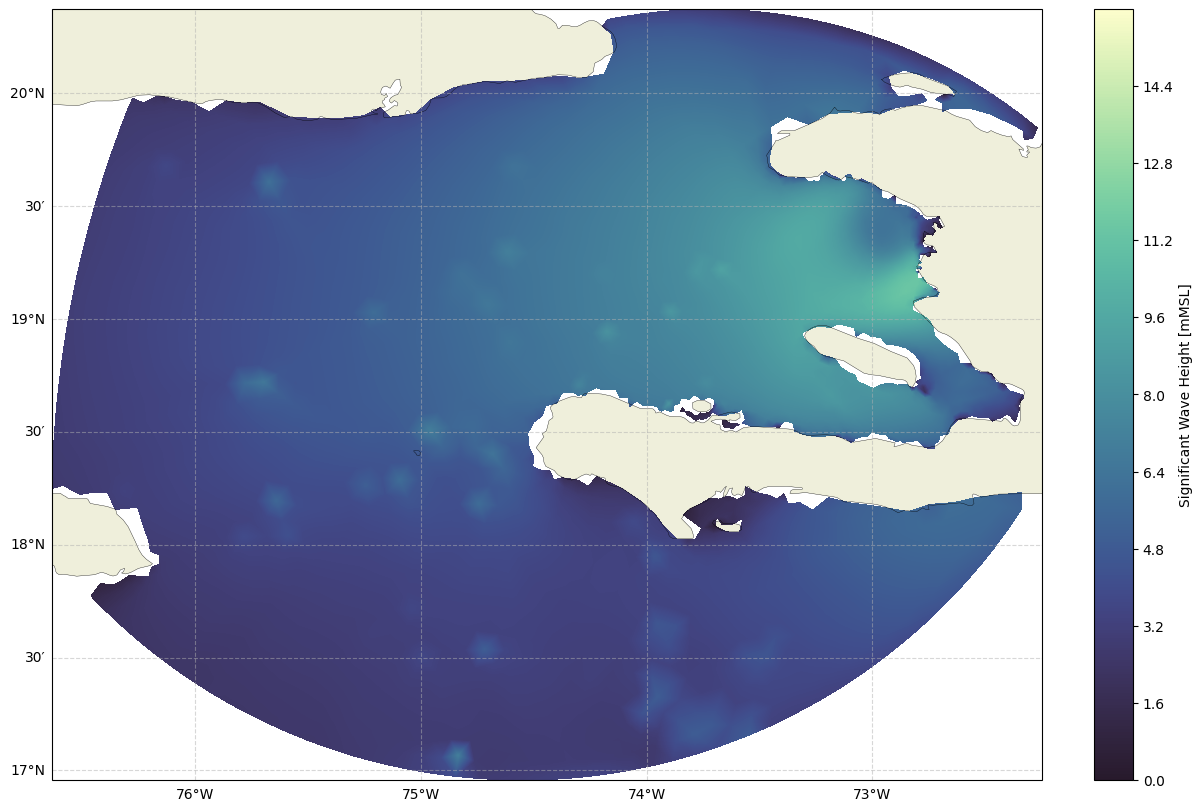

In [ ]:
fig, ax = plt.subplots(figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)

plot_nc(nc_HS, 'swan_HS', levels = np.arange(0., 16., 0.01),
        background_map = True, cbar = True, cb_label = 'Significant Wave Height [mMSL]',
        cmap = cmocean.cm.deep_r, ts = timestep, ax = ax, fig = fig)

In [ ]:
nc_DIR = netcdf.Dataset(hotstart_dir+'swan_DIR.63.nc', 'r')
variables = list(nc_DIR.variables.keys())
swan_HS_DIR = nc_HS.variables['swan_HS'][:]
print('Min: ' + str(swan_HS_DIR.min()))
print('Avg: ' + str(swan_HS_DIR.mean()))
print('Max: ' + str(swan_HS_DIR.max()))

Min: 1.5191132658457257e-18
Avg: 2.5479567005924455
Max: 16.71040153503418


(<Figure size 1200x800 with 2 Axes>,
 <GeoAxesSubplot: title={'center': 'Wave Direction (arrows) and Height at timestep: 44'}, xlabel='Longitude [deg]', ylabel='Latitude [deg]'>)

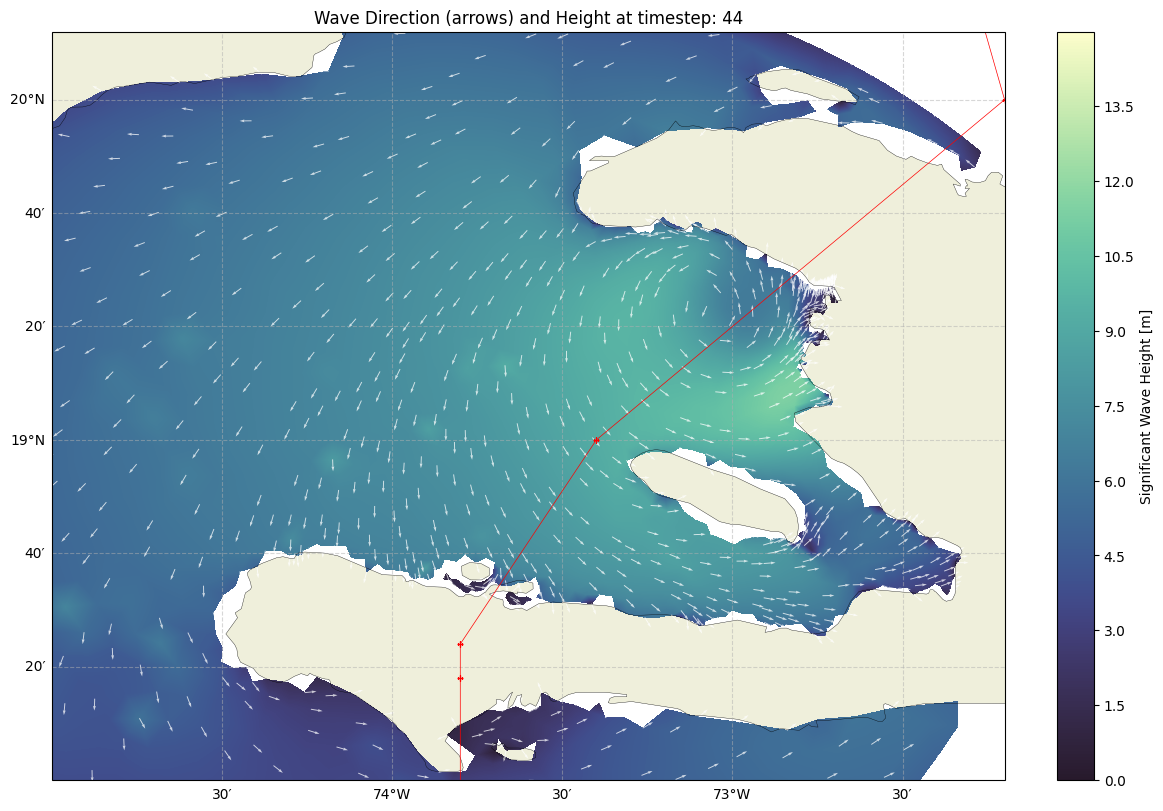

In [ ]:
track_df = get_hurricane_track(hotstart_dir + "fort.22")
plot_wave_direction_and_height(nc_HS, nc_DIR, track_df, timestep)

## Animation

In [ ]:
data = nc_f63 #nc_HS  
var = 'zeta' #'zeta'#'swan_HS' 

for i in tqdm(range(47), desc="Generating frames"):
        fig, ax = plt.subplots(figsize = (8,5), subplot_kw={'projection': ccrs.PlateCarree()}, 
                                        constrained_layout=True)
        timestep=i
        # significant wave height (0., 15., 0.01
        plot_nc(data, var, levels = np.arange(-0.5, 2., 0.01), 
                background_map = True, cbar = True, cb_label = 'Significant Wave Height [m]',
                cmap = cmocean.cm.deep_r, ts = timestep, ax = ax, fig = fig)

        # Get the coordinates and wave direction data
        x = nc_DIR.variables['x'][:]
        y = nc_DIR.variables['y'][:]
        dir_data = nc_DIR.variables['swan_DIR'][timestep, :]

        # Convert from oceanographic convention (where waves come from) to mathematical (where arrows point)
        # In oceanographic convention, 0° is from North, 90° is from East
        # For plotting arrows, we need to convert to mathematical angles where 0° is East and goes counterclockwise
        #math_angles = (270 - dir_data) % 360
        math_angles_rad = np.radians(dir_data)

        # Calculate u and v components for arrows
        u = np.cos(math_angles_rad)
        v = np.sin(math_angles_rad)

        # Skip points to make the plot clearer - show arrows at every nth point
        n = 2
        ax.quiver(x[::n], y[::n], u[::n], v[::n], 
                        scale=80, width=0.001, color='white', 
                        alpha=0.65,
                        transform=ccrs.PlateCarree())

        # Plot trajectory line
        ax.plot(track_df['Longitude'], track_df['Latitude'], '+-', linewidth=0.5, color='red', markersize=5)

        # Plot points at each time step
        ax.set_xlim(-75., -72.2)
        ax.set_ylim(18., 20.2)

        ax.set_title('Wave Direction (arrows) and Height at timestep: '+str(timestep))





        """n = plot_nc(data, var, 
                levels = np.arange(0, 15., 0.05), 
                background_map = True, 
                cbar = True, 
                cb_label = 'Max water level [mMSL]', 
                cmap = cmocean.cm.balance, 
                ts = i,  # Use frame as timestep
                xlims=xlims, 
                ylims=ylims,
                ncvec = nc2, 
                dxvec=0.05, 
                dyvec=0.05, 
                vecsc=700)  # Pass the axis to plot on"""
        
        # Add frame number for reference
        #n.set_title(f'Timestep {i}')
        #fig = n.figure
        # Save the frame
        frame_file = f'animation/ts_{i}.png'
        fig.savefig(frame_file, dpi=500, bbox_inches='tight')
        plt.close(fig)

Generating frames: 100%|██████████| 47/47 [00:41<00:00,  1.13it/s]


In [ ]:
import imageio
import os

title = 'ADCIRC+SWAN_HS+DIR_shifted_small.gif' #ADCIRC+SWAN_HS.gif'

def create_animation_with_imageio():
    print("Creating animation with imageio...")
    
    # Get all frame files
    frames = []
    for ts in range(47):
        frame_file = f'animation/ts_{ts}.png'
        if os.path.exists(frame_file):
            frames.append(frame_file)
        else:
            print(f"Warning: File {frame_file} does not exist!")
    
    if not frames:
        print("No frames found!")
        return
    
    print(f"Found {len(frames)} frames")
    
    # Create GIF
    images = []
    for frame in frames:
        try:
            images.append(imageio.imread(frame))
        except Exception as e:
            print(f"Error reading {frame}: {str(e)}")
    
    if images:
        print(f"Creating GIF with {len(images)} images")
        imageio.mimsave('exports/'+title, images, fps=12, loop=0)
        print("Animation saved to exports/" + title)
    else:
        print("No images could be loaded")

# Try the alternative method
try:
    import imageio
    create_animation_with_imageio()
except ImportError:
    print("imageio not installed. Try: pip install imageio")

Creating animation with imageio...
Found 47 frames
Creating GIF with 47 images
Animation saved to exports/ADCIRC+SWAN_HS+DIR_shifted_small.gif
